# MNIST Digit Recognition

## Imports

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import pickle

## Read the dataset

In [2]:
mnist = fetch_openml('mnist_784', version=1, parser="auto", as_frame=False)
X, y = mnist["data"], mnist["target"]

In [3]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

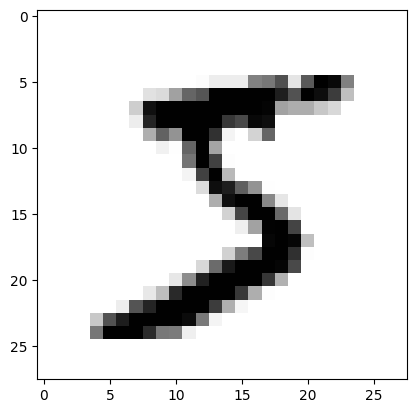

In [4]:
digit = X[0]
digit_image = digit.reshape(28, 28)
plt.imshow(digit_image, cmap="binary")
plt.show()

In [5]:
y[0]

'5'

In [6]:
y = y.astype(np.uint8)

## Test split
The dataset is already split 60.000 - 10.000

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classifier
5 detector

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd.predict([digit])[0]

True

In [10]:
cross_val_score(sgd, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Only 10% of the images are 5's, always guessing the image is not a five would give a model accurate 90% of the times. Therefore, accuracy is not the preferred performance metric.

In [11]:
y_train_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3)

In [12]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])


| TN | FN |
|----|----|
| FP | TP |

In [13]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

It's right 83% of the times.

In [14]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

It only detects 65% of he 5's

In [15]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [16]:
y_score = sgd.decision_function([digit])
threshold = 0
y_pred = y_score > threshold
y_pred[0]

True

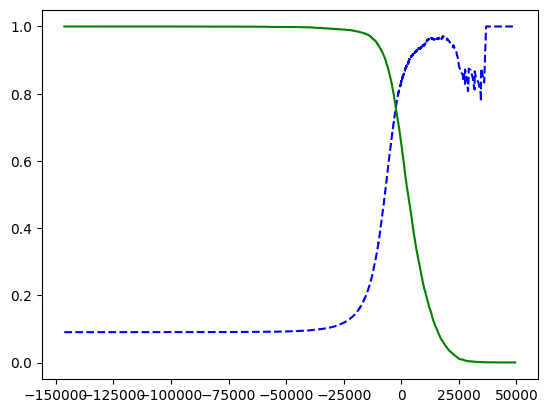

In [17]:
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.show()

In [18]:
threshold_90_precision = thresholds[np.argmax(precisions > 0.90)]
y_pred_90 = (y_scores >= threshold_90_precision)

In [19]:
precision_score(y_train_5, y_pred_90)

0.9000345901072293

In [20]:
recall_score(y_train_5, y_pred_90)

0.4799852425751706

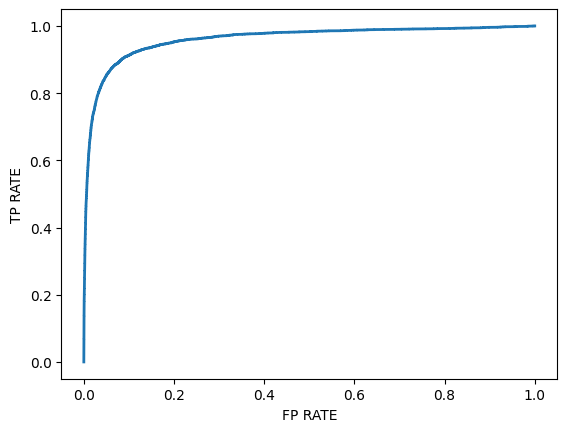

In [21]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plt.xlabel("FP RATE")
plt.ylabel("TP RATE")
plt.plot(fpr, tpr, linewidth=2)
plt.show()

In [22]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [23]:
forest = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest, X_train, y_train_5, cv=3, method="predict_proba")

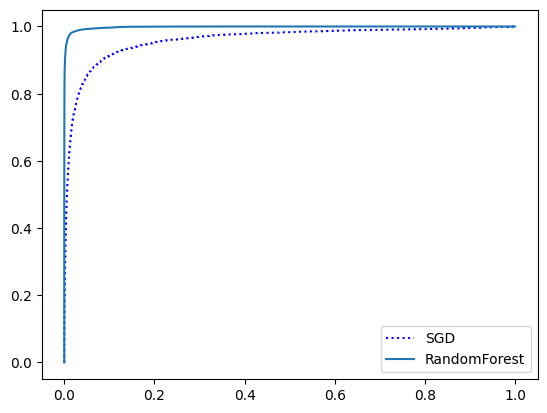

In [24]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="RandomForest")
plt.legend(loc = "lower right")
plt.show()

In [25]:
roc_auc_score(y_train_5, y_scores_forest)


0.9983436731328145

## Multiclass Classification

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring="accuracy", n_jobs=1)

array([0.8983, 0.891 , 0.9018])

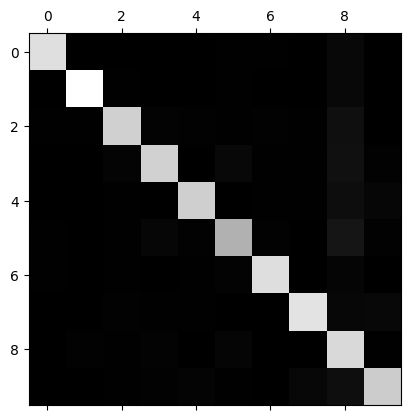

In [27]:
y_train_preds = cross_val_predict(sgd, X_train_scaled, y_train, cv=3, n_jobs=1)
confusion_matrix = confusion_matrix(y_train, y_train_preds)
plt.matshow(confusion_matrix, cmap=plt.cm.gray)
plt.show()

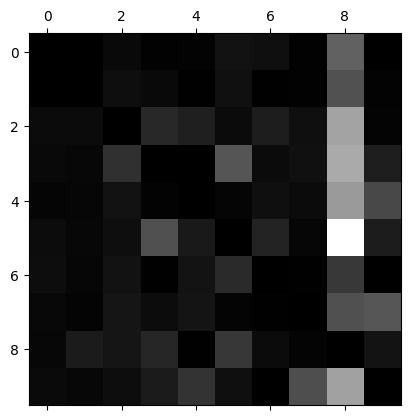

In [28]:
row_sums = confusion_matrix.sum(axis=1, keepdims=True)
norm_confusion_matrix = confusion_matrix / row_sums
np.fill_diagonal(norm_confusion_matrix, 0)
plt.matshow(norm_confusion_matrix, cmap=plt.cm.gray)
plt.show()

3's an 5's confused both ways and many digits get misclassified as 8 even though 8 gets mostly classified correctly.

## Multilabel Classification

In [29]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn = KNeighborsClassifier()
knn.fit(X_train, y_multilabel)
knn.predict([digit])

array([[False,  True]])

## Multioutput Classification

In [30]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

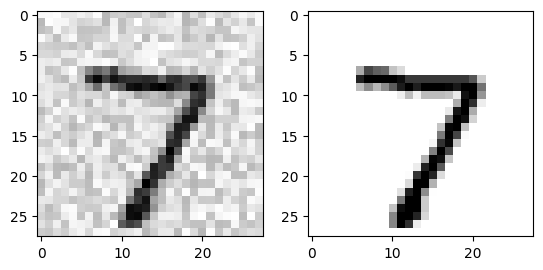

In [31]:

plt.subplot(121); plt.imshow(X_test_mod[0].reshape(28, 28), cmap="binary")
plt.subplot(122); plt.imshow(y_test_mod[0].reshape(28, 28), cmap="binary")
plt.show()

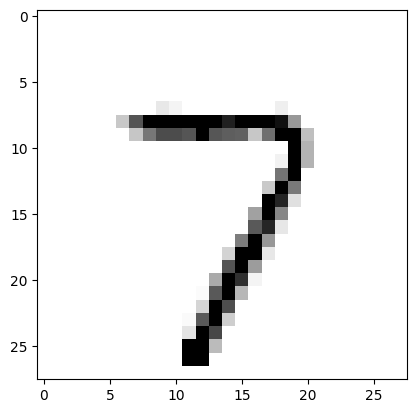

In [32]:
knn = KNeighborsClassifier()
knn.fit(X_train_mod, y_train_mod)
cleaned_digit = knn.predict([X_test_mod[0]])
plt.imshow(cleaned_digit.reshape(28, 28), cmap="binary")
plt.show()

## Exercises

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    "n_neighbors" : [3, 4, 5, 7],
    "weights" : ["uniform", "distance"]
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=3, scoring="accuracy", n_jobs=6)

In [34]:
grid_search.fit(X_train, y_train)
knn_opt = grid_search.best_estimator_

preds = knn_opt.predict(X_test)
accuracy_score(preds, y_test)

0.9714

In [35]:
from scipy.ndimage import shift

def shift_digit(dx, dy, digit):
    digit_image = digit.reshape(28, 28)
    shifted_image = shift(digit_image, [dx, dy], cval=0)
    return shifted_image.reshape([-1])

X_train_extended = [digit for digit in X_train]
y_train_extended = [digit for digit in y_train]

for digit, label in zip(X_train, y_train):
    for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
        X_train_extended.append(shift_digit(dx, dy, digit))
        y_train_extended.append(label)

In [36]:
X_train_extended = np.array(X_train_extended)
y_train_extended = np.array(y_train_extended)

shuffle_idx = np.random.permutation(len(X_train_extended))
X_train_extended = X_train_extended[shuffle_idx]
y_train_extended = y_train_extended[shuffle_idx]

In [37]:
knn = KNeighborsClassifier(**grid_search.best_params_)
knn.fit(X_train_extended, y_train_extended)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [38]:
preds = knn.predict(X_test)
accuracy_score(y_test, preds)

0.9763

In [39]:
import joblib
joblib.dump(knn, 'model.joblib')

['model.joblib']